<h1>LSTM_Autoencoder with OCSVM outlier Detection and LSTM Forecasting</h1>

<h4>Has Auto params for LSTM and SVM</h4>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

# BayesianOptimization
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization # for OCSVM param
from kerastuner.tuners import BayesianOptimization # for LSTM param

# Anomaly detector
import itertools
from sklearn.svm import OneClassSVM

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\2242330462.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization # for LSTM param


<h4>Importing Datasets</h4>

In [2]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [3]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [4]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [5]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [6]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [7]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [8]:
# Global selection
sel_country = old_df[2]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1320,ECS010230100302,010000357415,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-11,40,HC,1200.0
1321,ECS010230100303,010000380481,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-16,40,HC,1200.0
1323,ECS010230100304,010000392586,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1322,ECS010230100304,010000390964,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0
1324,ECS010230100304,010000399293,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-02-24,40,HC,1200.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1325 non-null   object        
 1   CNTR_ID     1325 non-null   object        
 2   POD_ID      1325 non-null   object        
 3   ETD_POL_D   1325 non-null   object        
 4   PARTY_ID    1325 non-null   object        
 5   PARTY_NAME  1325 non-null   object        
 6   POD         1325 non-null   datetime64[ns]
 7   CNTR_SIZE   1325 non-null   object        
 8   CNTR_TYPE   1325 non-null   object        
 9   RATE        1325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 113.9+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600278,CTNR010050700692,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-23,40,HC,1200.0
1,ECS01050600280,CTNR010050701022,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-07-30,40,HC,1200.0
2,ECS010050700458,CTNR010050800604,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-16,40,HC,1000.0
3,ECS010050700214,CTNR010050800727,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-08-19,40,HC,1200.0
4,ECS010050900271,CTNR010051000178,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2005-10-11,40,HC,900.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1336,ECS010230300518,010000531211,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1337,ECS010230300518,010000509487,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-04-28,40,HC,500.0
1338,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
1339,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
1340,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 0 to 1340
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1341 non-null   object        
 1   CNTR_ID     1341 non-null   object        
 2   POD_ID      1341 non-null   object        
 3   ETD_POL_D   1341 non-null   object        
 4   PARTY_ID    1341 non-null   object        
 5   PARTY_NAME  1341 non-null   object        
 6   POD         1341 non-null   datetime64[ns]
 7   CNTR_SIZE   1341 non-null   object        
 8   CNTR_TYPE   1341 non-null   object        
 9   RATE        1341 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 115.2+ KB


In [9]:
# Select features
sel_feat = ['POD','RATE']
robust_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning
robust_df.head()
robust_df.info()

,POD,RATE
0,2005-07-23,1200.0
1,2005-07-30,1200.0
2,2005-08-16,1000.0
3,2005-08-19,1200.0
4,2005-10-11,900.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1325 entries, 0 to 1324
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1325 non-null   datetime64[ns]
 1   RATE    1325 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.1 KB


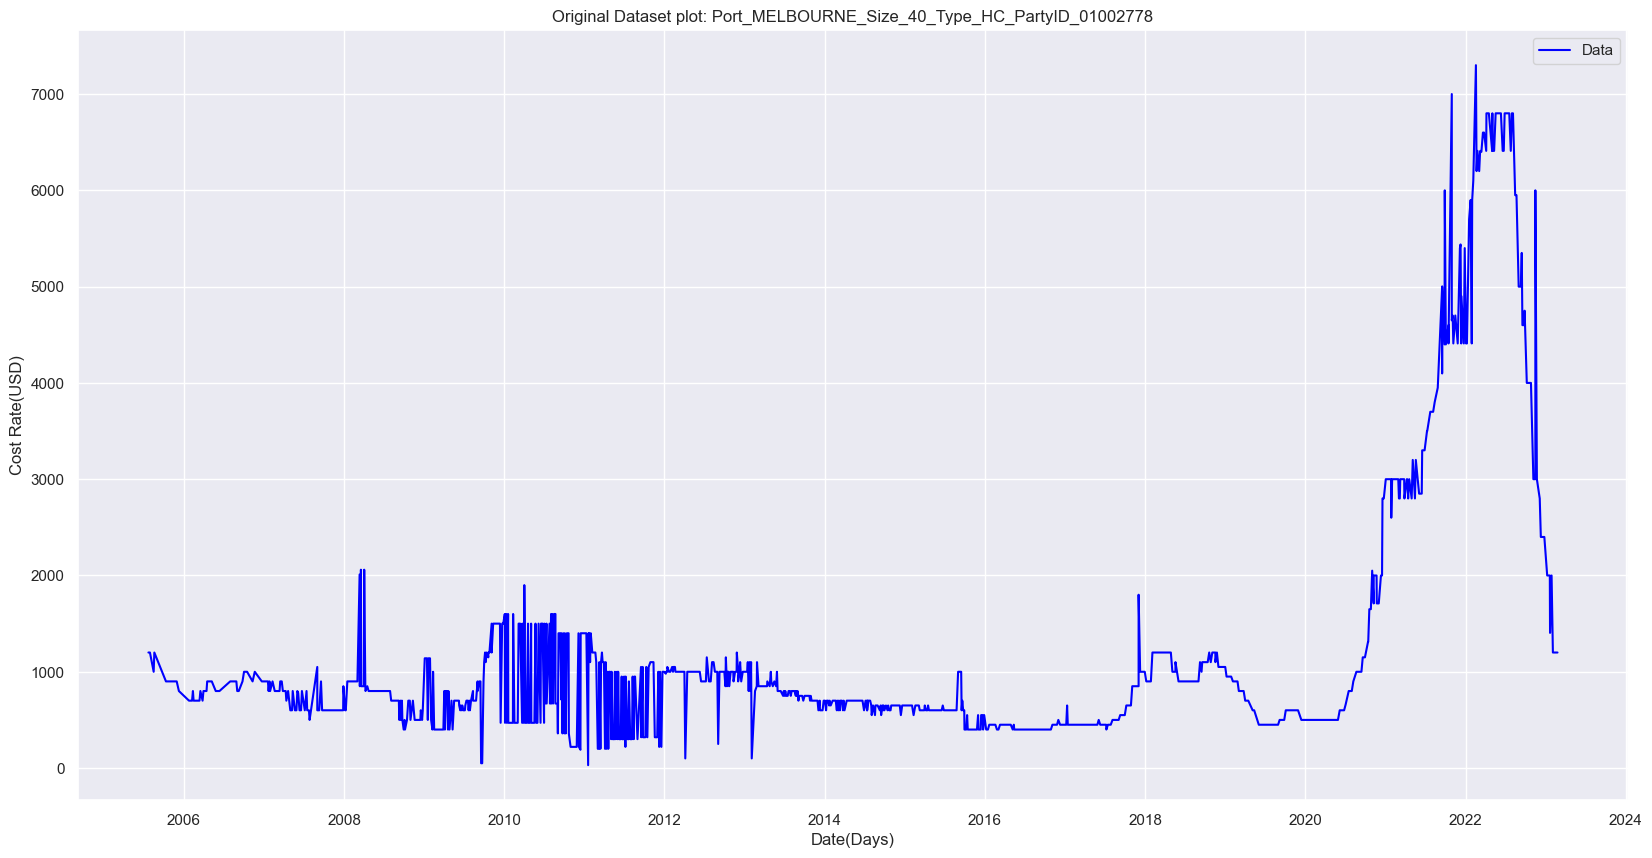

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(robust_df['POD'], robust_df['RATE'], color='blue', label="Data")

plt.xlabel('Date(Days)')
plt.ylabel('Cost Rate(USD)')
plt.title(f'Original Dataset plot: {sel_country}')
plt.legend()
plt.show();

<h2>Annomaly Detection using LSTM Autoencoder with OCSVM</h2>

<h4>Finding best params for LSTM auto-encoder and nu for one class svm</h4>

In [11]:
# Preprocessing: scaling data to [-1, 1] range

# Instantiate the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(robust_df['RATE'].values.reshape(-1, 1))

In [12]:
# # Define model builder function
# def build_model(hp):
#     model = Sequential([
#         LSTM(hp.Int('input_units', min_value=32, max_value=256, step=32), 
#              activation='relu', 
#              input_shape=(time_steps, 1), 
#              return_sequences=False),
#         RepeatVector(time_steps),
#         LSTM(hp.Int('output_units', min_value=32, max_value=256, step=32), 
#              activation='relu', 
#              return_sequences=True),
#         TimeDistributed(Dense(1))
#     ])
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss=MeanSquaredError())
#     return model

# # Preprocessing: scaling data to [0, 1] range
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(robust_df['RATE'].values.reshape(-1, 1))

# # Define your time_steps
# time_steps = 20

# # Creating a series generator for the LSTM autoencoder
# series_gen = TimeseriesGenerator(data_scaled, data_scaled, length=time_steps, batch_size=32)

# # Instantiate tuner
# tuner = BayesianOptimization(
#     build_model,
#     objective='loss',
#     max_trials=10,
#     executions_per_trial=2,
#     directory='my_dir',
#     project_name='lstm_autoencoder')

# # Perform hyperparameter search
# tuner.search(series_gen, epochs=50)

# # Get the best hyperparameters for LSTM
# best_lstm_params = tuner.get_best_hyperparameters()[0].values

In [13]:
# def ocsvm_cv(nu, data, targets):
#     estimator = OneClassSVM(nu=nu)
#     cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=5)
#     return cval.mean()

# def optimize_ocsvm(data, targets):
#     def ocsvm_crossval(nu):
#         return ocsvm_cv(nu = nu, data=data, targets=targets)
    
#     optimizer = BayesianOptimization(
#         f=ocsvm_crossval,
#         pbounds={"nu": (0.01, 0.5)},
#         random_state=1234,
#         verbose=2
#     )
#     optimizer.maximize(n_iter=15)
    
#     print("Final result:", optimizer.max)
#     return optimizer.max['params']['nu']


In [14]:
# # Get the best hyperparameters for LSTM
# best_lstm_params = tuner.get_best_hyperparameters()[0].values
# print(f'Best LSTM Autoencoder param: {best_lstm_params}')

# # Get the best nu for One-Class SVM
# best_svm_nu = best_nu
# print(f'Best svm param: {best_svm_nu}')


In [15]:
# Define a result list
results = []

# Define the hyperparameters grid
param_grid = {
    'lstm_units': [64, 128],
    'time_steps': [10, 20],
    'batch_size': [16, 32],
    'epochs': [30, 50]
}

# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

# Create a random hyperparameters sampler
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Start the manual random search
for params in param_list:
    # Extract parameters from current combination
    lstm_units, time_steps, batch_size, epochs = params['lstm_units'], params['time_steps'], params['batch_size'], params['epochs']
    
    # Create generator with current time_steps
    series_gen = TimeseriesGenerator(data_scaled, data_scaled, length=time_steps, batch_size=batch_size)
    
    # Create and train model with current hyperparameters
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=(time_steps, 1), return_sequences=False),
        RepeatVector(time_steps),
        LSTM(lstm_units, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(series_gen, epochs=epochs, verbose=0, callbacks=[early_stopping])
    
    # Calculate final loss
    final_loss = history.history['loss'][-1]
    
    # Append current hyperparameters and result to results list
    results.append((params, final_loss))

# Print results
for params, final_loss in results:
    print(f'Parameters: {params}, loss={final_loss}')
    

# Find best parameters
best_params, best_loss = min(results, key=lambda x: x[1])


Parameters: {'time_steps': 10, 'lstm_units': 64, 'epochs': 30, 'batch_size': 16}, loss=0.007545164320617914
Parameters: {'time_steps': 20, 'lstm_units': 64, 'epochs': 30, 'batch_size': 16}, loss=0.008178251795470715
Parameters: {'time_steps': 20, 'lstm_units': 64, 'epochs': 50, 'batch_size': 16}, loss=0.008813522756099701
Parameters: {'time_steps': 10, 'lstm_units': 128, 'epochs': 50, 'batch_size': 32}, loss=0.010133531875908375
Parameters: {'time_steps': 20, 'lstm_units': 64, 'epochs': 50, 'batch_size': 32}, loss=0.009144986979663372
Parameters: {'time_steps': 20, 'lstm_units': 128, 'epochs': 30, 'batch_size': 32}, loss=0.009268511086702347
Parameters: {'time_steps': 10, 'lstm_units': 64, 'epochs': 30, 'batch_size': 32}, loss=0.009025509469211102
Parameters: {'time_steps': 20, 'lstm_units': 64, 'epochs': 30, 'batch_size': 32}, loss=0.012775596231222153
Parameters: {'time_steps': 10, 'lstm_units': 128, 'epochs': 30, 'batch_size': 16}, loss=0.00843016803264618
Parameters: {'time_steps':

In [16]:
# Extracting parameters from best_params
time_steps = best_params['time_steps']
batch_size = best_params['batch_size']
lstm_units = best_params['lstm_units']
epochs = best_params['epochs']

# Creating a series generator for the LSTM autoencoder
series_gen = TimeseriesGenerator(data_scaled, data_scaled,
                                 length=time_steps, batch_size=batch_size)

# LSTM autoencoder
model = Sequential([
    LSTM(lstm_units, activation='relu', input_shape=(time_steps, 1), return_sequences=False),
    RepeatVector(time_steps),
    LSTM(lstm_units, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')
model.fit(series_gen, epochs=epochs)

# Calculating reconstruction error
preds = model.predict(series_gen)

# Reshape data_scaled to match preds' shape
data_scaled_reshaped = np.array([data_scaled[i-time_steps:i] for i in range(time_steps, len(data_scaled))])

# Calculate mean square error
errors = np.mean(np.square(preds - data_scaled_reshaped), axis=(1, 2))

Epoch 1/30
83/83 [==============================] - 3s 8ms/step - loss: 0.1366
Epoch 2/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0228
Epoch 3/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0150
Epoch 4/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0127
Epoch 5/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0110
Epoch 6/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 7/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0113
Epoch 8/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 9/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 10/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0095
Epoch 11/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0094
Epoch 12/30
83/83 [==============================] - 1s 7ms/step - loss: 0.0088
Epoch 13/30
83/83 [==============================

83/83 [==============================] - 1s 3ms/step


In [17]:
# Define a list of possible nu values
nu_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

best_nu = 0
best_score = float('inf')

# Loop over the nu_values
for nu in nu_values:
    # Using One-Class SVM for anomaly detection
    ocsvm = OneClassSVM(nu=nu)
    ocsvm.fit(errors.reshape(-1, 1))
    anomaly_flags = ocsvm.predict(errors.reshape(-1, 1))

    # Count the number of anomalies detected
    num_anomalies = sum(anomaly_flags == -1)

    # Calculate the mean square error of anomalies
    mse_anomalies = np.mean(errors[anomaly_flags == -1])

    # Combine num_anomalies and mse_anomalies into a score
    # This is just one example of how to score. You should adjust this to fit your needs.
    score = num_anomalies * mse_anomalies

    # If the score for this nu value is better than our current best, update best_nu and best_score
    if score < best_score:
        best_nu = nu
        best_score = score

    print(f"nu: {nu}, score: {score}")

print(f"Best nu: {best_nu}, best score: {best_score}")


OneClassSVM(nu=0.01)

nu: 0.01, score: 2.258995330014784


OneClassSVM(nu=0.02)

nu: 0.02, score: 2.5677244733962308


OneClassSVM(nu=0.05)

nu: 0.05, score: 3.2672967754699163


OneClassSVM(nu=0.1)

nu: 0.1, score: 5.2045622082557825


OneClassSVM(nu=0.2)

nu: 0.2, score: 7.195510966546799


OneClassSVM()

nu: 0.5, score: 9.451053179481146
Best nu: 0.01, best score: 2.258995330014784


In [18]:
# Using One-Class SVM for anomaly detection
ocsvm = OneClassSVM(nu=0.5)
ocsvm.fit(errors.reshape(-1, 1))
anomaly_flags = ocsvm.predict(errors.reshape(-1, 1))

# Marking anomalies in the data
robust_df['Anomaly'] = 0
robust_df.iloc[time_steps:len(preds) + time_steps, robust_df.columns.get_loc('Anomaly')] = anomaly_flags

# If you want to exclude anomalies from the data:
df_no_anomalies = robust_df[robust_df['Anomaly'] != -1]


OneClassSVM()

<Figure size 2000x1000 with 0 Axes>

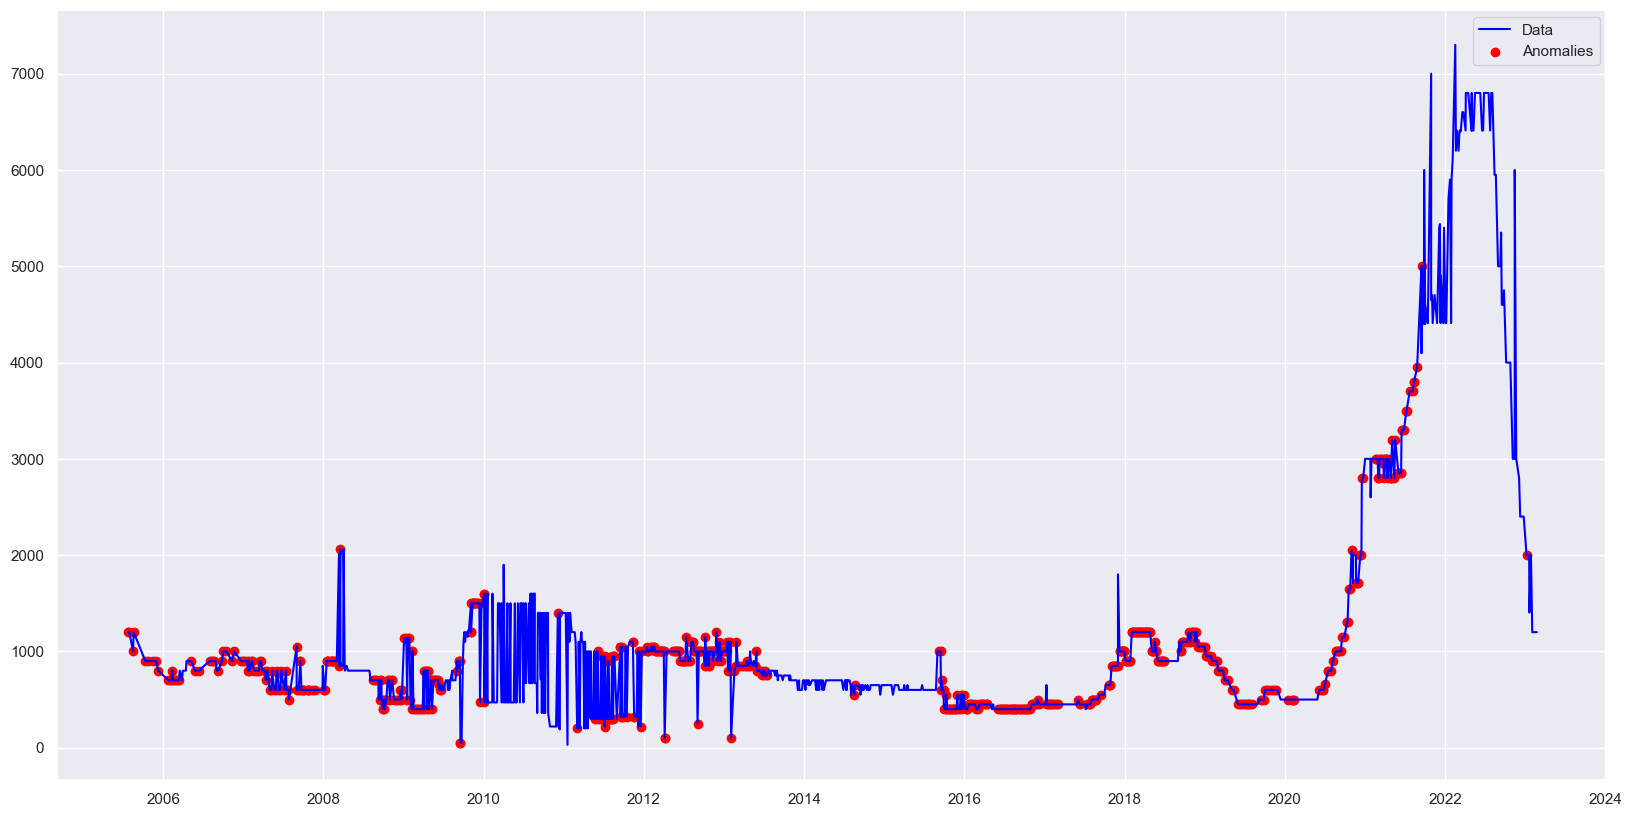

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(robust_df['POD'], robust_df['RATE'], color='blue', label="Data")
plt.scatter(df_no_anomalies['POD'], df_no_anomalies['RATE'], color='red', label="Anomalies")
plt.legend()
plt.show()

<h4>Handling Anomaly</h4>

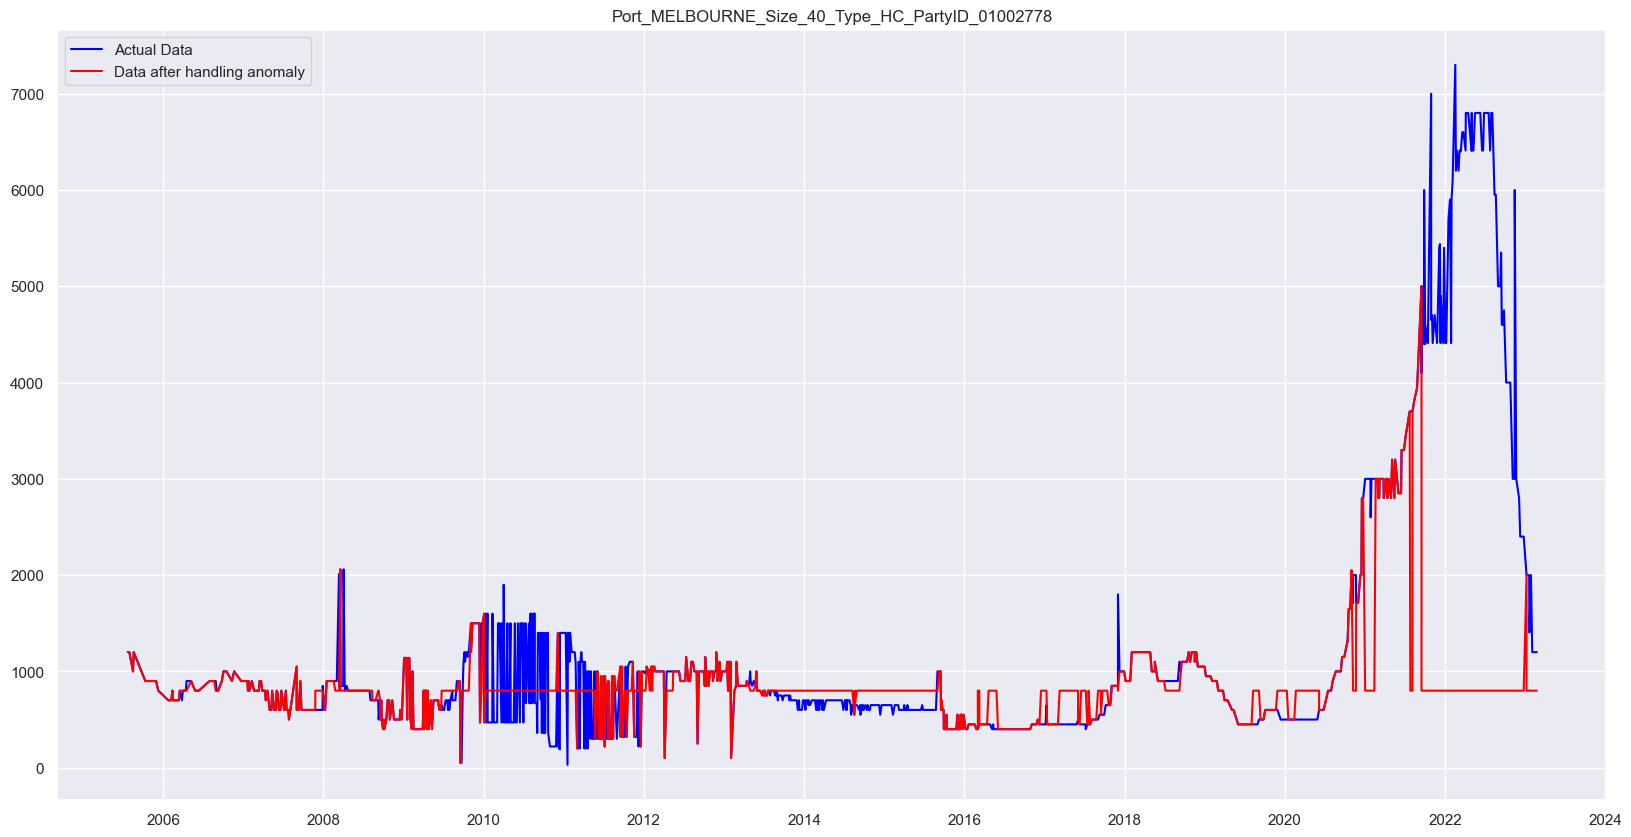

In [20]:
# calculate skewness
skewness = skew(robust_df['RATE'])

# if skewness is high, fill anomalies with median, else fill with mean
if abs(skewness) > 0.5:
    robust_df.loc[robust_df['Anomaly'] == -1, 'RATE'] = robust_df['RATE'].median()
else:
    robust_df.loc[robust_df['Anomaly'] == -1, 'RATE'] = robust_df['RATE'].mean()
  
# Plot to visualise
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(robust_df['POD'], robust_df['RATE'], color='Red', label="Data after handling anomaly")
plt.title(sel_country)
plt.legend()
plt.show();

In [21]:
# Remove Anomaly column
without_ann = ['POD','RATE']
robust_df = robust_df[without_ann]

<h4>Interpolate missing values in between dates</h4>

In [22]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-07-23,1200.0
1,2005-07-24,1200.0
2,2005-07-25,1200.0
3,2005-07-26,1200.0
4,2005-07-27,1200.0


,POD,RATE
6449,2023-02-20,800.0
6450,2023-02-21,800.0
6451,2023-02-22,800.0
6452,2023-02-23,800.0
6453,2023-02-24,800.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6454 entries, 0 to 6453
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6454 non-null   datetime64[ns]
 1   RATE    6454 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 151.3 KB


<h4>Grouping it to week</h4>

In [23]:
from scipy import stats

# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\679132877.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be remov

,YearMonthWeek,Rate
0,2005-07-18,1200.00
1,2005-07-25,1198.32
2,2005-08-01,1141.18
3,2005-08-08,1058.82
4,2005-08-15,1113.54
5,2005-08-22,1166.04
6,2005-08-29,1126.42
7,2005-09-05,1086.79
8,2005-09-12,1047.17
9,2005-09-19,1007.55


,YearMonthWeek,Rate
903,2022-11-07,800.00
904,2022-11-14,800.00
905,2022-11-21,800.00
906,2022-11-28,800.00
907,2022-12-05,800.00
908,2022-12-12,800.00
909,2022-12-19,800.00
910,2022-12-26,1076.92
911,2023-01-02,1607.69
912,2023-01-09,800.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  918 non-null    datetime64[ns]
 1   Rate           918 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.5 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [24]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200328,010000409869,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-02,40,HC,1000.0
1,ECS010230200329,010000419018,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-10,40,HC,1000.0
2,ECS010230200330,010000427048,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-03-16,40,HC,1000.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
13,ECS010230400431,010000541165,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-05,40,HC,500.0
14,ECS010230400432,010000543217,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-11,40,HC,500.0
15,ECS010230400433,010000557443,MELBOURNE,AUMEL,01002778,GLOBELINK INTERNATIONAL PTY LTD-MELBOURNE,2023-05-19,40,HC,400.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      16 non-null     object        
 1   CNTR_ID     16 non-null     object        
 2   POD_ID      16 non-null     object        
 3   ETD_POL_D   16 non-null     object        
 4   PARTY_ID    16 non-null     object        
 5   PARTY_NAME  16 non-null     object        
 6   POD         16 non-null     datetime64[ns]
 7   CNTR_SIZE   16 non-null     object        
 8   CNTR_TYPE   16 non-null     object        
 9   RATE        16 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.4+ KB


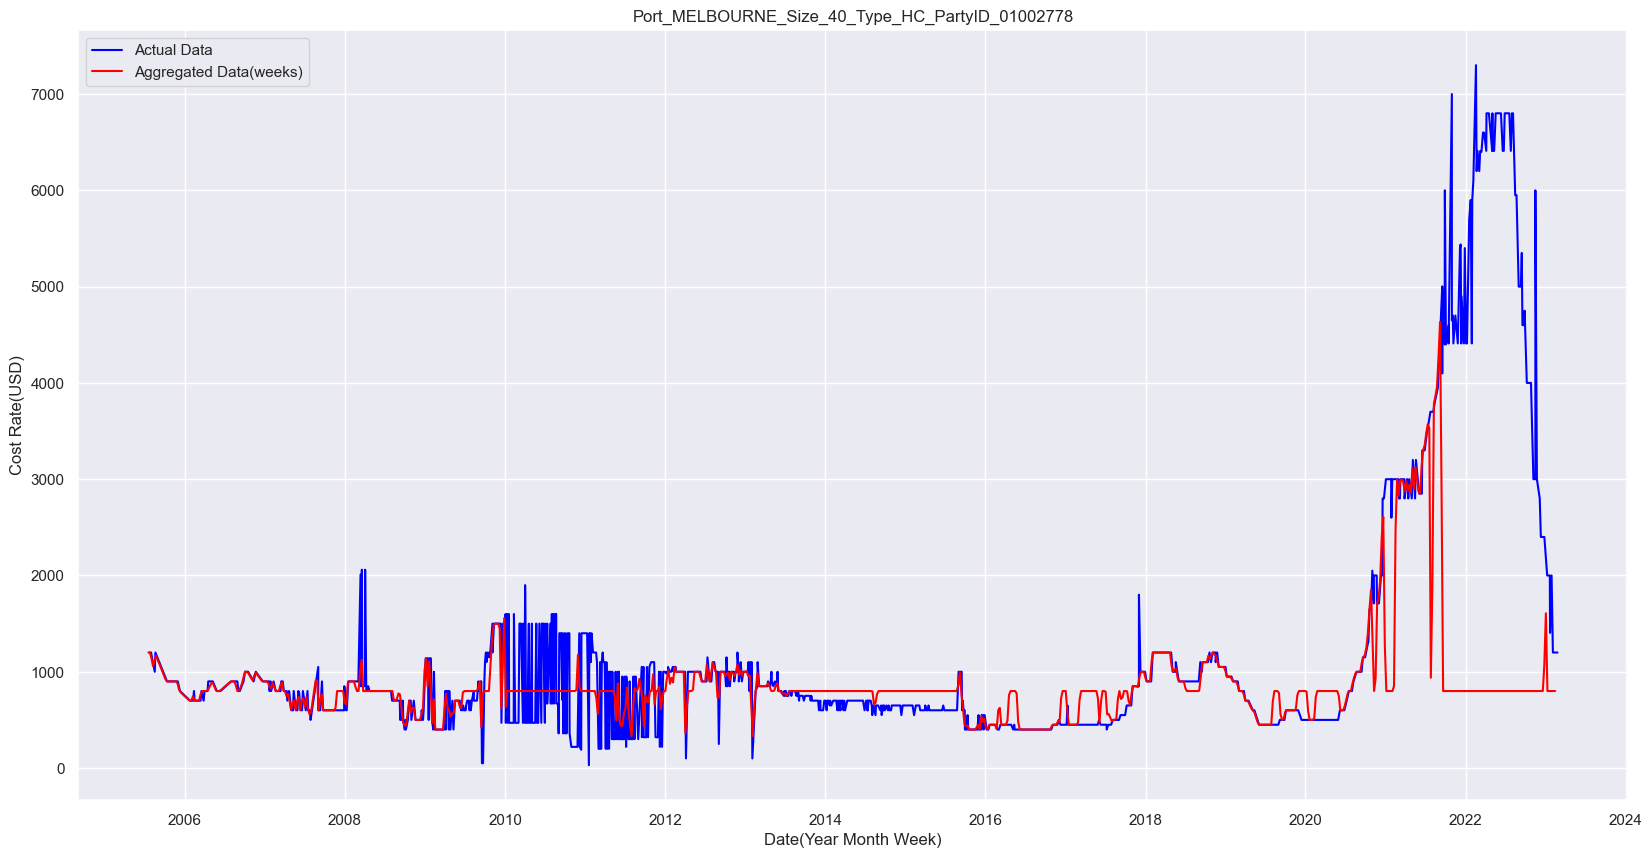

In [25]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>LSTM Regression<h4>

In [26]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()
    
    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, input_shape=(look_back, trainX.shape[2]), 
                           activation='tanh', recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(0.01)))
        else:
            # Middle layers return sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, activation='tanh', 
                           recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))
    model.summary()

    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2, 
                        validation_data=(testX, testY), callbacks=[es])
    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_23 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_24 (LSTM)              (None, 5, 32)             12416     
                                                                 
 dropout_2 (Dropout)         (None, 5, 32)             0         
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 153.65 RMSE for 50 epochs
Test Score: 743.60 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_12 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_35 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_13 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_36 (LSTM)              (None, 5, 16)             3136      
                                                             

9/9 [==============================] - 0s 5ms/step
Train Score: 153.50 RMSE for 50 epochs
Test Score: 742.99 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 5, 16)             1152      
                                                                 
 dropout_22 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_45 (LSTM)              (None, 5, 16)             2112      
                                                                 
 dropout_23 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_46 (LSTM)              (None, 5, 8)              800       
                                                                 
 dr

9/9 [==============================] - 0s 4ms/step
Train Score: 153.48 RMSE for 50 epochs
Test Score: 742.93 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 5, 8)              320       
                                                                 
 dropout_30 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_53 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_31 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_54 (LSTM)              (None, 5, 4)              208       
                                                                 
 dropout_32

9/9 [==============================] - 0s 3ms/step
Train Score: 154.88 RMSE for 50 epochs
Test Score: 747.38 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 5, 4)              96        
                                                                 
 dropout_36 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_59 (LSTM)              (None, 5, 4)              144       
                                                                 
 dropout_37 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_60 (LSTM)              (None, 5, 2)              56        
                                                                 
 dropout_38 (Drop

9/9 [==============================] - 0s 2ms/step
Train Score: 154.30 RMSE for 50 epochs
Test Score: 746.75 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 5, 2)              32        
                                                                 
 dropout_40 (Dropout)        (None, 5, 2)              0         
                                                                 
 lstm_63 (LSTM)              (None, 2)                 40        
                                                                 
 dropout_41 (Dropout)        (None, 2)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Traina

9/9 [==============================] - 0s 2ms/step
Train Score: 156.28 RMSE for 50 epochs
Test Score: 758.54 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_42 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_65 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dropout_43 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_66 (LSTM)              (None, 5, 32)             12416     
                          

9/9 [==============================] - 0s 5ms/step
Train Score: 152.98 RMSE for 100 epochs
Test Score: 740.46 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 5, 32)             4352      
                                                                 
 dropout_54 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_77 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_55 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_78 (LSTM)              (None, 5, 16)             3136      
                                                           

9/9 [==============================] - 0s 5ms/step
Train Score: 152.86 RMSE for 100 epochs
Test Score: 739.71 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 5, 16)             1152      
                                                                 
 dropout_64 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_87 (LSTM)              (None, 5, 16)             2112      
                                                                 
 dropout_65 (Dropout)        (None, 5, 16)             0         
                                                                 
 lstm_88 (LSTM)              (None, 5, 8)              800       
                                                                 
 

9/9 [==============================] - 0s 4ms/step
Train Score: 152.93 RMSE for 100 epochs
Test Score: 740.18 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_94 (LSTM)              (None, 5, 8)              320       
                                                                 
 dropout_72 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_95 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_73 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_96 (LSTM)              (None, 5, 4)              208       
                                                                 
 dropout_

9/9 [==============================] - 0s 3ms/step
Train Score: 152.91 RMSE for 100 epochs
Test Score: 740.06 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_78 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_101 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_79 (Dropout)        (None, 5, 4)              0         
                                                                 
 lstm_102 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_80 (Dr

9/9 [==============================] - 0s 2ms/step
Train Score: 152.87 RMSE for 100 epochs
Test Score: 739.76 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_82 (Dropout)        (None, 5, 2)              0         
                                                                 
 lstm_105 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_83 (Dropout)        (None, 2)                 0         
                                                                 
 dense_22 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Trai

9/9 [==============================] - 0s 2ms/step
Train Score: 154.82 RMSE for 100 epochs
Test Score: 750.05 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_84 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_107 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_85 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_108 (LSTM)             (None, 5, 32)             12416     
                        

9/9 [==============================] - 0s 6ms/step
Train Score: 152.72 RMSE for 150 epochs
Test Score: 738.55 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_118 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_96 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_119 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_97 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_120 (LSTM)             (None, 5, 16)             3136      
                                                           

9/9 [==============================] - 0s 5ms/step
Train Score: 152.68 RMSE for 150 epochs
Test Score: 738.06 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_106 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_129 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_107 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_130 (LSTM)             (None, 5, 8)              800       
                                                                 
 

9/9 [==============================] - 0s 4ms/step
Train Score: 152.64 RMSE for 150 epochs
Test Score: 737.51 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_136 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_114 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_137 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_115 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_138 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout_

9/9 [==============================] - 0s 3ms/step
Train Score: 152.68 RMSE for 150 epochs
Test Score: 738.03 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_142 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_120 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_143 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_121 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_144 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_122 (D

9/9 [==============================] - 0s 2ms/step
Train Score: 152.67 RMSE for 150 epochs
Test Score: 737.88 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_146 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_124 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_147 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_125 (Dropout)       (None, 2)                 0         
                                                                 
 dense_28 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Trai

9/9 [==============================] - 0s 2ms/step
Train Score: 154.43 RMSE for 150 epochs
Test Score: 748.07 RMSE for 150 epochs


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

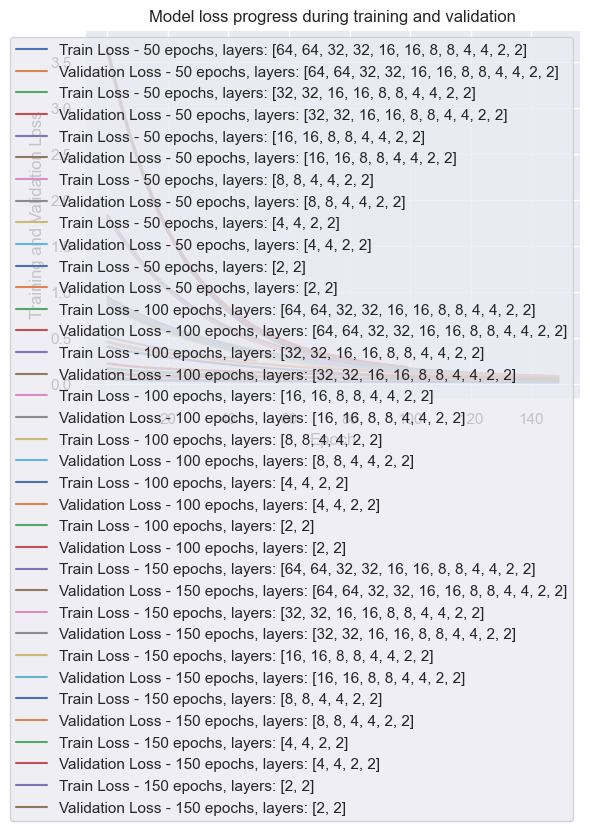

                                                    Train RMSE   Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...  153.654783  743.602040
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...  153.497852  742.990712
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        153.482629  742.928834
50 epochs, [8, 8, 4, 4, 2, 2] layers                154.880800  747.382756
50 epochs, [4, 4, 2, 2] layers                      154.302611  746.747454
50 epochs, [2, 2] layers                            156.282888  758.540786
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...  152.976834  740.461338
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...  152.862603  739.707280
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers       152.932254  740.181876
100 epochs, [8, 8, 4, 4, 2, 2] layers               152.913396  740.058089
100 epochs, [4, 4, 2, 2] layers                     152.869513  739.762802
100 epochs, [2, 2] layers                           154.819256  750.052129
150 epochs, [64, 64, 32, 

In [27]:
# Normalize dataset for LSTM
from sklearn.preprocessing import MinMaxScaler

# Initialize two separate scalers
scaler_rate = MinMaxScaler(feature_range=(0, 1))

# Fit and transform 'RATE' and 'during_covid' separately
rate_scaled = scaler_rate.fit_transform(agg_df[['Rate']])

# Concatenate the scaled data
dataset = np.concatenate([rate_scaled], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    
    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers)
        
        # Add the loss for this model to the plot
        plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY_orig = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY_orig = scaler.inverse_transform([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Configure and show the plot
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.show();

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

<h4>Forecast the results</h4>

In [28]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100

def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)
        input_values_scaled = scaler.transform(last_values_2d)
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        prediction = model.predict(input_values_scaled)
        prediction = scaler.inverse_transform(prediction)
        forecast.append(prediction[0][0])
        last_values.append(prediction[0][0])

    return forecast



In [29]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(model, look_back, scaler, last_values, weeks)
forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 20ms/step


,POD,RATE
0,2023-02-26,4075.310059
1,2023-03-05,4068.699951
2,2023-03-12,4056.810059
3,2023-03-19,4043.959961
4,2023-03-26,4032.409912


,POD,RATE
7,2023-04-16,4023.449951
8,2023-04-23,4023.560059
9,2023-04-30,4023.629883
10,2023-05-07,4023.649902
11,2023-05-14,4023.649902


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [30]:
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_21176\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\U

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-02-26,2023-03-05,2023-03-02,4075.310059,1000.0,-207.531006
1,2023-03-05,2023-03-12,2023-03-10,4068.699951,1000.0,-206.869995
2,2023-03-12,2023-03-19,2023-03-16,4056.810059,1000.0,-205.681006
3,2023-03-19,2023-03-26,2023-03-21,4043.959961,600.0,-473.993327
4,2023-03-26,2023-04-02,2023-03-26,4032.409912,600.0,-472.068319
5,2023-03-26,2023-04-02,2023-03-31,4032.409912,650.0,-420.370756
6,2023-04-02,2023-04-09,2023-04-06,4023.110107,650.0,-418.940017
7,2023-04-09,2023-04-16,2023-04-13,4023.290039,650.0,-418.967698
8,2023-04-16,2023-04-23,2023-04-20,4023.449951,650.0,-418.992300
9,2023-04-23,2023-04-30,2023-04-28,4023.560059,500.0,-604.712012


The mean accuracy is -451.04%



<h4>Visualise all, Conclusion</h4>

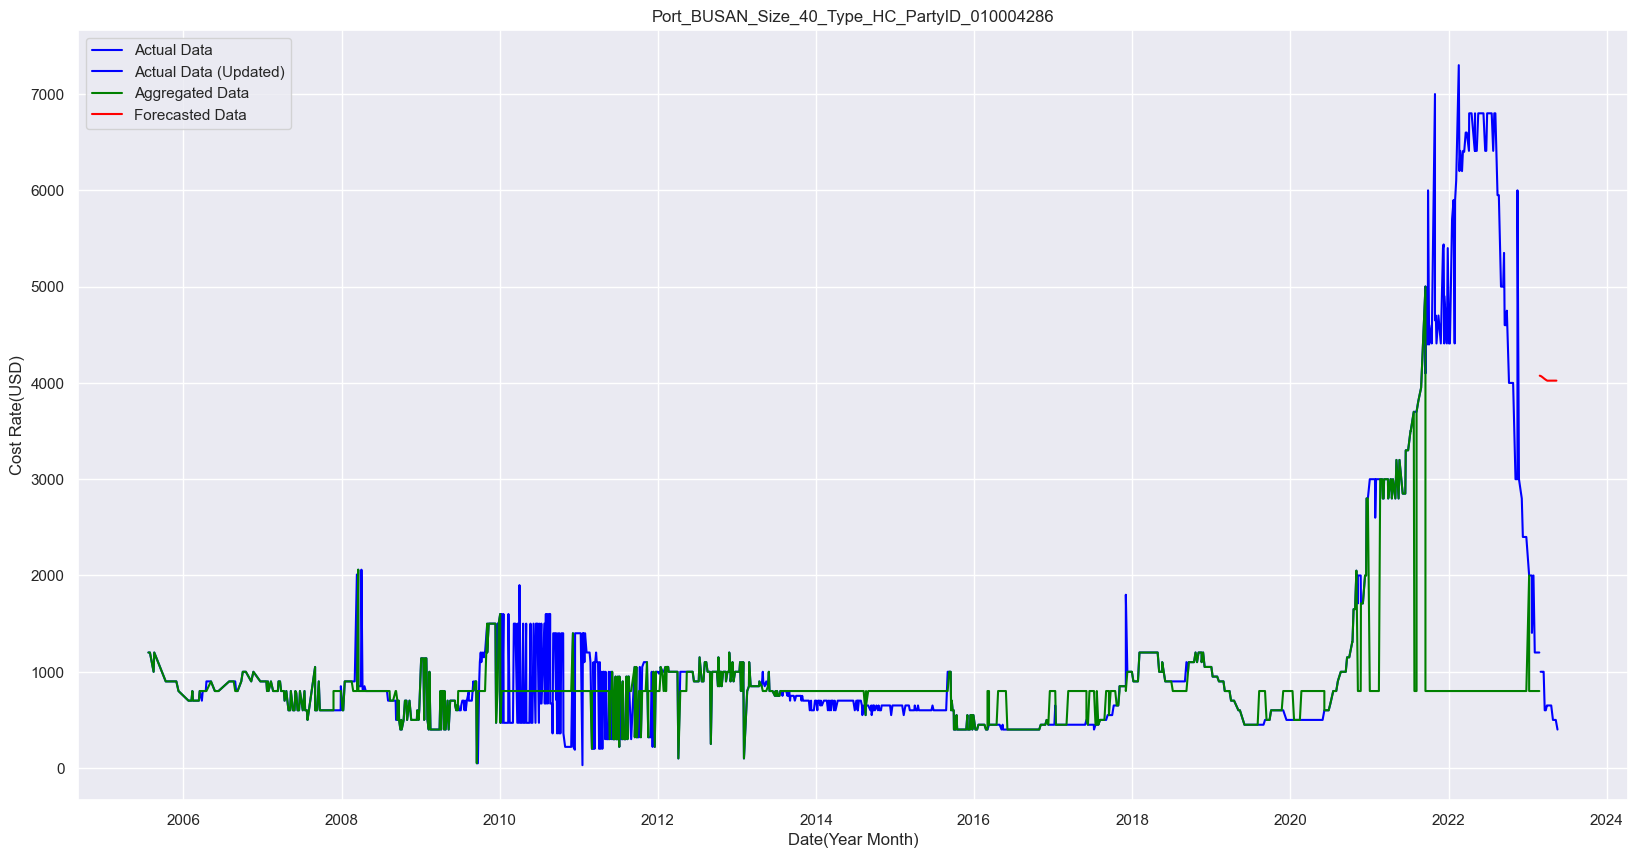

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();